In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

import kernelbiome.kernels_jax as kj
import kernelbiome.metrics_jax as mj
import kernelbiome.nested_cv as ncv
import kernelbiome.cfi_and_cpd as imp
import kernelbiome.utils_cv as ncvutil
import kernelbiome.utils_result as ncvres
import kernelbiome.kernel_mds as kmds

import warnings
warnings.filterwarnings('always')

/Users/hrt620/.pyenv/versions/3.9.9/envs/kb39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


### Simulate data

In [2]:
seed_num = 2022
rng = np.random.default_rng(seed_num)

(200, 9)


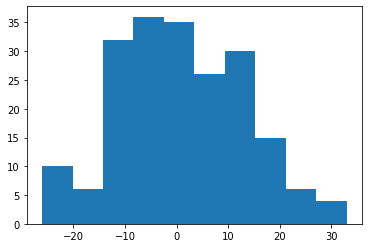

In [3]:
p = 9
n = 200
mu = [0,0,0]
cov = [[1, 0.25, -0.25],
       [0.25, 1, 0.25],
       [-0.25, 0.25, 1]]

X1 = rng.multivariate_normal(mu, cov, n) # 0, 1, 2
X2 = rng.multivariate_normal(mu, cov, n) # 3, 4, 5
X3 = rng.multivariate_normal(mu, cov, n) # 6, 7, 8

X = np.concatenate([X1, X2, X3], axis=1)
X = np.exp(X)
X /= X.sum(axis=1)[:,None]
print(X.shape)

def true_fun(X):
    return 10*np.log(X[:,0]) - 5*np.log(X[:,4]) - 5*np.log(X[:,8])

y = true_fun(X) + rng.normal(0,1,n)

plt.hist(y)
plt.show()

In [4]:
idx_shuffle = rng.choice(range(X.shape[0]), X.shape[0], replace=False)
X = X[idx_shuffle]
y = y[idx_shuffle]

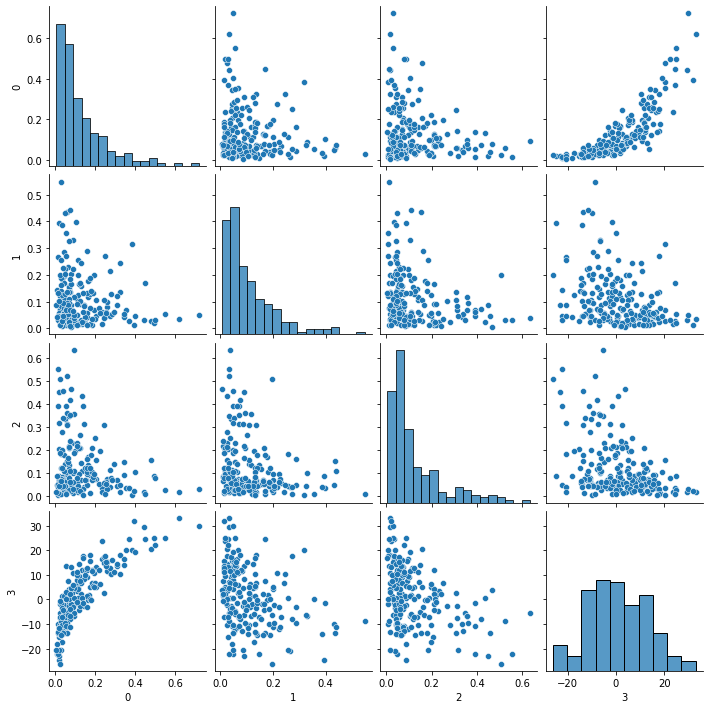

In [5]:
sns.pairplot(pd.DataFrame(np.concatenate([X[:,[0,4,8]],y[:,None]],axis=1)))

### Setup kernel parameter grid

In [6]:
# kernel models
kernel_params_dict = ncvutil.default_kernel_params_grid()
kmat_with_params = ncvutil.get_kmat_with_params(kernel_params_dict)

# add RF and baseline
mod_with_params = kmat_with_params
mod_with_params['RF use comp'] = None
mod_with_params['baseline'] = None

len(mod_with_params)

60

### Setup hyperparameter grid

In [7]:
n_fold_outer = 10
n_fold_inner = 5
scoring = 'neg_mean_squared_error'
n_jobs = 6

param_grid_svm = dict(C=[10**x for x in [-2,-1,0,1,2]])
print(param_grid_svm)
param_grid_kr = dict(alpha=[1/2**x for x in [-1,0,1,2,3,4,5]])
print(param_grid_kr)
param_grid_rf = dict(n_estimators=[10, 20, 50, 100, 250, 500])
print(param_grid_rf)
param_grid_baseline = dict(strategy = ["mean", "median"])
print(param_grid_baseline)

{'C': [0.01, 0.1, 1, 10, 100]}
{'alpha': [2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125]}
{'n_estimators': [10, 20, 50, 100, 250, 500]}
{'strategy': ['mean', 'median']}


### Run nested CV

In [8]:
train_scores_all, test_scores_all, selected_params_all = ncv.run_experiments(X, y,
                                                                             kmat_with_params,
                                                                             param_grid_kr,
                                                                             param_grid_rf,
                                                                             param_grid_baseline,
                                                                             center_kmat=True,
                                                                             n_fold_outer=10,
                                                                             n_fold_inner=5,
                                                                             type='regression',
                                                                             scoring='neg_mean_squared_error',
                                                                             kernel_estimator='kr',
                                                                             n_jobs=-1,
                                                                             random_state=seed_num,
                                                                             verbose=0)
clear_output()

#### Show full results

In [9]:
ncvres.make_result_table(mod_with_params, train_scores_all, test_scores_all, selected_params_all)

avg_train_score  avg_test_score  \
kernel         kernel_params                                            
RF use comp    NaN                          -2.155069      -15.636660   
aitchison      c_0.001                      -0.992350       -1.066019   
               c_0.0001                     -0.992859       -1.071689   
               c_1e-05                      -0.995501       -1.075284   
               c_1e-06                      -0.995794       -1.075677   
               c_1e-07                      -0.995824       -1.075717   
aitchison-rbf  c_1e-07_g_0.01               -0.805347       -1.557884   
               c_1e-06_g_0.01               -0.805363       -1.558043   
               c_1e-05_g_0.01               -0.805665       -1.558196   
               c_0.0001_g_0.01              -0.807294       -1.559601   
               c_0.001_g_0.01               -0.827770       -1.581355   
               c_0.001_g_0.1                -0.896694      -10.804860   
               c_0.0001_g_0.1               -0.917874      -11.393858   
               c_1e-05_g_0.1                -0.920359      -11.463752   
               c_1e-07_g_0.1                -0.920640      -11.468690   
               c_1e-06_g_0.1                -0.920589      -11.469945   
               c_0.001_g_1.0                -0.065937     -116.267693   
               c_0.0001_g_1.0               -0.066108     -118.414933   
               c_1e-05_g_1.0                -0.066181     -118.625977   
               c_1e-06_g_1.0                -0.066091     -118.648338   
               c_1e-07_g_1.0                -0.065840     -118.651678   
               c_0.001_g_10.0              -29.702155     -147.443060   
               c_0.0001_g_10.0             -29.702322     -147.445861   
               c_1e-06_g_10.0              -29.702335     -147.445889   
               c_1e-07_g_10.0              -29.702302     -147.446102   
               c_1e-05_g_10.0              -29.702289     -147.446167   
               c_1e-07_g_100.0             -29.703624     -147.468666   
               c_1e-06_g_100.0             -29.703624     -147.468666   
               c_1e-05_g_100.0             -29.703624     -147.468666   
               c_0.0001_g_100.0            -29.703624     -147.468666   
               c_0.001_g_100.0             -29.703624     -147.468666   
baseline       NaN                        -147.402545     -148.724973   
generalized-js a_inf_b_0.5                  -0.068288       -2.954714   
               a_10_b_0.5                   -0.195212       -2.991355   
               a_10_b_1                     -0.195227       -3.157846   
               a_inf_b_1                    -0.068499       -3.431112   
               a_10_b_10                    -0.103686       -6.253450   
               a_inf_b_10                   -0.067061      -10.544552   
               a_inf_b_inf                  -0.066590      -15.061651   
               a_1_b_1                     -29.952881      -32.046609   
               a_1_b_0.5                   -45.762342      -47.800059   
heat-diffusion t_0.08753521870054244        -0.066335      -29.112382   
               t_0.08355634512324506        -0.066186      -30.735784   
               t_0.07957747154594767        -0.066071      -32.524272   
               t_0.07559859796865029        -0.066306      -34.501309   
               t_0.0716197243913529         -0.065952      -36.698143   
hilbertian     a_inf_b_-1                   -0.068678       -2.655176   
               a_10_b_-1                    -0.211278       -2.875973   
               a_1_b_-10                    -0.183582       -3.176405   
               a_inf_b_-10                  -0.538164       -3.272677   
               a_10_b_-inf                  -0.533521       -3.295176   
               a_10_b_-10                   -1.040210       -3.372361   
               a_1_b_-inf                   -0.068513       -3.431103   
               a_1_b_-1

#### Show only top models in each group

In [10]:
best_models = ncvres.top_models_in_each_group(mod_with_params, train_scores_all, test_scores_all, selected_params_all, top_n=1, kernel_mod_only=False)
best_models

,estimator_key,kmat_fun,avg_test_score,most_freq_best_param
27,aitchison_c_0.001,<function wrap.<locals>.calc at 0x17d2b49d0>,-1.066019,1.255328
28,aitchison-rbf_c_1e-07_g_0.01,<function wrap.<locals>.calc at 0x17d2b4a60>,-1.557884,0.004118
21,hilbertian_a_inf_b_-1,<function wrap.<locals>.calc at 0x17c4ca8b0>,-2.655176,0.000664
11,generalized-js_a_inf_b_0.5,<function wrap.<locals>.calc at 0x17c4ca1f0>,-2.954714,0.001129
3,rbf_g_1.0,<function wrap.<locals>.calc at 0x17c4b8e50>,-13.728172,0.00397
58,RF use comp,None,-15.636660,250
57,heat-diffusion_t_0.08753521870054244,<function wrap.<locals>.calc at 0x17d2b5af0>,-29.112382,0.000262
0,linear,<function kmat_linear at 0x16c5f1dc0>,-41.071978,1.250072
59,baseline,None,-148.724973,mean


#### Show only top kernel models

In [11]:
best_kernel_models = ncvres.top_models_in_each_group(mod_with_params, train_scores_all, test_scores_all, selected_params_all, top_n=1, kernel_mod_only=True)
best_kernel_models

,estimator_key,kmat_fun,avg_test_score,most_freq_best_param
27,aitchison_c_0.001,<function wrap.<locals>.calc at 0x17d2b49d0>,-1.066019,1.255328
28,aitchison-rbf_c_1e-07_g_0.01,<function wrap.<locals>.calc at 0x17d2b4a60>,-1.557884,0.004118
21,hilbertian_a_inf_b_-1,<function wrap.<locals>.calc at 0x17c4ca8b0>,-2.655176,0.000664
11,generalized-js_a_inf_b_0.5,<function wrap.<locals>.calc at 0x17c4ca1f0>,-2.954714,0.001129
3,rbf_g_1.0,<function wrap.<locals>.calc at 0x17c4b8e50>,-13.728172,0.00397
57,heat-diffusion_t_0.08753521870054244,<function wrap.<locals>.calc at 0x17d2b5af0>,-29.112382,0.000262
0,linear,<function kmat_linear at 0x16c5f1dc0>,-41.071978,1.250072


#### CFI and CPD

In [12]:
colors_all = np.vstack([plt.cm.tab20c(range(20)),plt.cm.tab20b(range(20))]) # plt.cm.tab10(range(10)), plt.cm.tab20(range(20)), plt.cm.tab20b(range(20)), 
colors_all = np.unique(colors_all, axis=0)
print(colors_all.shape)

(40, 4)


In [13]:
best_model = best_kernel_models.iloc[0]
pred_fun, gscv = ncv.refit_best_model(X, y, 'KernelRidge', param_grid_kr, best_model, scoring, center_kmat=True)
print(gscv.best_estimator_)
k_fun = ncvres.kernel_args_str_to_k_fun(best_model.estimator_key)
df = imp.df_ke_dual_mat(X, X, gscv.best_estimator_.dual_coef_, range(n), k_fun)
cfi_vals = imp.get_cfi(X, df)
cpd_vals = imp.get_cpd(X, X, pred_fun)

rank_tol: 0.007103344250936061
scale_tol: 10^-3.0
None {'alpha': array([0.00710334, 1.25532751, 2.50355167, 3.75177584, 5.        ])}
KernelRidge(alpha=1.255327508188202, kernel='precomputed')


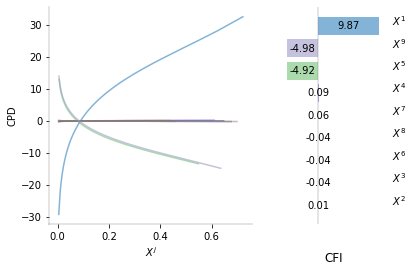

In [14]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
imp.plot_cpd(X, cpd_vals, labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[0])
imp.plot_cfi(cfi_vals, fmt='%.2f', labels=[f'$X^{jj+1}$' for jj in range(X.shape[1])], colors=colors_all[::2], axs=axs[1], ascending=False)
plt.show()

#### Dimensionality reduction

In [15]:
Z1 = kmds.Phi(X, X, best_model.kmat_fun, center=True, pc=0, return_mean=False)
Z2 = kmds.Phi(X, X, best_model.kmat_fun, center=True, pc=1, return_mean=False)

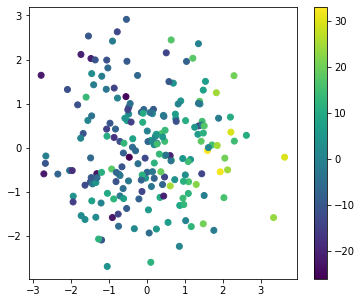

In [16]:
fig, axs = plt.subplots(1,1, figsize=(6,5))
im = axs.scatter(Z1, Z2, c=y)
plt.colorbar(im)
plt.show()